## Directory and Structure
```
|-- evaluate.ipynb
|-- train.ipynb
|-- backbone.pth.tar               # VGG16 backbone pretrained on SHT Part_A
|-- ShanghaiTech
    |-- part_A
        |-- test_data 
            |-- images             # Contain the testing images
            |-- images-pt          # Contain the features of training images in .pt format (Auto generated)
            |-- ground-truth       # Contain the ground-truth of training images in .mat format
            |-- ground-truth-csv   # Contain the ground-truth of testing images in .csv format (Auto generated)
        |-- train_data    
            |-- images             # Contain the training images
            |-- images-pt          # Contain the features of training images in .pt format (Auto generated)
            |-- ground-truth       # Contain the ground-truth of training images in .mat format
            |-- ground-truth-csv   # Contain the ground-truth of training images in .csv format (Auto generated)
            
    |-- part_B
        |-- test_data
            |-- images
            |-- ground-truth
        |-- train_data
            |-- images
            |-- ground-truth
|-- Models                         # Contain the trained models
|-- Results                        # Contain the logs of the training

```

## Load all the require library and settings

In [1]:
import torch
import numpy as np
import time
import cv2
import shutil
import pandas as pd
import scipy.io as sio
from scipy.io import loadmat
import os
from torchvision import transforms
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision.models import vgg16

from model import *
from utility import *

device            = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
USE_PYTORCH_VGG16 = False

print("Device Used:",device)
print("Use Pre-trained VGG-16 from","pytorch" if USE_PYTORCH_VGG16 else "Journal 'Counting Objects by Blockwise Classification' ")

Device Used: cuda
Use Pre-trained VGG-16 from Journal 'Counting Objects by Blockwise Classification' 


In [2]:
# The dataset is download from kaggle https://www.kaggle.com/datasets/tthien/shanghaitech/data
part_A_dir    = "ShanghaiTech/part_A/"
part_B_dir    = "ShanghaiTech/part_B/"

# Select the dataset used
dataset_used  = "Part A"
if dataset_used == "Part A":
    dataset_dir = part_A_dir
elif dataset_used == "Part B":
    dataset_dir = part_B_dir

In [3]:
# Get the directory to each of the files
train_img_dir = "train_data/images/"
train_gt_dir  = "train_data/ground-truth/"
train_img_pt  = "train_data/images-pt/"
train_gt_csv  = "train_data/ground-truth-csv/"

test_img_dir  = "test_data/images/"
test_gt_dir   = "test_data/ground-truth/"
test_img_pt   = "test_data/images-pt/"
test_gt_csv   = "test_data/ground-truth-csv/"

# Contain list of path that directly point to the file 
train_img_dir_list = [dataset_dir + train_img_dir + filename for filename in sorted(os.listdir(dataset_dir + train_img_dir)) if filename.endswith(".jpg")]
train_gt_dir_list  = [dataset_dir + train_gt_dir  + filename for filename in sorted(os.listdir(dataset_dir + train_gt_dir)) if filename.endswith(".mat")]

test_img_dir_list  = [dataset_dir + test_img_dir + filename for filename in sorted(os.listdir(dataset_dir + test_img_dir)) if filename.endswith(".jpg")]
test_gt_dir_list   = [dataset_dir + test_gt_dir  + filename for filename in sorted(os.listdir(dataset_dir + test_gt_dir)) if filename.endswith(".mat")]

print("Number of training data:",len(train_gt_dir_list))
print("Number of testing  data:",len(test_gt_dir_list))

Number of training data: 300
Number of testing  data: 182


## Analyze and Visualize the dataset

In [4]:
# Look on the shape of image
shape_count = {}
max_x       = 0
max_y       = 0

for img_filename in train_img_dir_list:
    img       = cv2.imread(img_filename)
    img_shape = img.shape 
    if img_shape not in shape_count:
        shape_count[img_shape] = 1
    else:
        shape_count[img_shape] += 1
        
    if img_shape[0] > max_x:
        max_x = img_shape[0]
    if img_shape[1] > max_y:
        max_y = img_shape[1]

print("Number of image        :", len(train_img_dir_list))
print("Number of unique shape :", len(shape_count))
print("Max x, y               :", max_x, max_y)
print(shape_count)

Number of image        : 300
Number of unique shape : 189
Max x, y               : 1024 1024
{(768, 1024, 3): 38, (683, 1024, 3): 22, (654, 1024, 3): 1, (400, 400, 3): 1, (405, 540, 3): 1, (632, 990, 3): 1, (675, 1024, 3): 1, (517, 800, 3): 1, (767, 1024, 3): 1, (681, 1024, 3): 11, (686, 1024, 3): 4, (498, 1024, 3): 1, (327, 1024, 3): 1, (390, 600, 3): 1, (375, 500, 3): 2, (611, 1021, 3): 1, (640, 640, 3): 1, (579, 840, 3): 1, (651, 1024, 3): 1, (594, 1024, 3): 1, (680, 1024, 3): 6, (373, 561, 3): 1, (787, 1024, 3): 1, (774, 1024, 3): 1, (565, 849, 3): 1, (576, 1024, 3): 5, (300, 400, 3): 1, (689, 998, 3): 1, (747, 1024, 3): 1, (498, 390, 3): 1, (800, 600, 3): 2, (1024, 1024, 3): 3, (182, 420, 3): 1, (500, 666, 3): 1, (585, 1024, 3): 1, (652, 1024, 3): 1, (370, 545, 3): 1, (645, 1024, 3): 2, (427, 640, 3): 1, (455, 670, 3): 1, (605, 1024, 3): 1, (561, 1024, 3): 1, (450, 970, 3): 1, (449, 716, 3): 1, (600, 800, 3): 3, (400, 600, 3): 3, (416, 624, 3): 1, (409, 620, 3): 1, (625, 1024, 3):

In [5]:
original_num_grid = 0
padding_num_grid  = max_x / 32 * max_y / 32 * len(train_img_dir_list)

for img_shape, count in shape_count.items():
    original_num_grid += np.ceil(img_shape[0] / 32) * np.ceil(img_shape[1] / 32) * count
    
print("Original     , number of grid to train :", original_num_grid)
print("After padding, number of grid to train :", padding_num_grid)
print("Number of extra grid                   :", padding_num_grid - original_num_grid)

Original     , number of grid to train : 164566.0
After padding, number of grid to train : 307200.0
Number of extra grid                   : 142634.0


In [6]:
# Annotation structure, the annotation is at matlab format storing the list of points
# Each of the point represent a person 
annots = loadmat(train_gt_dir_list[0])
print(train_gt_dir_list[0])
print(annots)                   
print("Point annotation",annots["image_info"][0][0][0][0][0])

ShanghaiTech/part_A/train_data/ground-truth/GT_IMG_1.mat
{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri Nov 18 20:06:05 2016', '__version__': '1.0', '__globals__': [], 'image_info': array([[array([[(array([[ 29.6225116 , 472.92022152],
                       [ 54.35533603, 454.96602305],
                       [ 51.79045053, 460.46220626],
                       ...,
                       [597.89732076, 688.27900015],
                       [965.77518336, 638.44693908],
                       [166.9965574 , 628.1873971 ]]), array([[1546]], dtype=uint16))]],
              dtype=[('location', 'O'), ('number', 'O')])                               ]],
      dtype=object)}
Point annotation [[ 29.6225116  472.92022152]
 [ 54.35533603 454.96602305]
 [ 51.79045053 460.46220626]
 ...
 [597.89732076 688.27900015]
 [965.77518336 638.44693908]
 [166.9965574  628.1873971 ]]


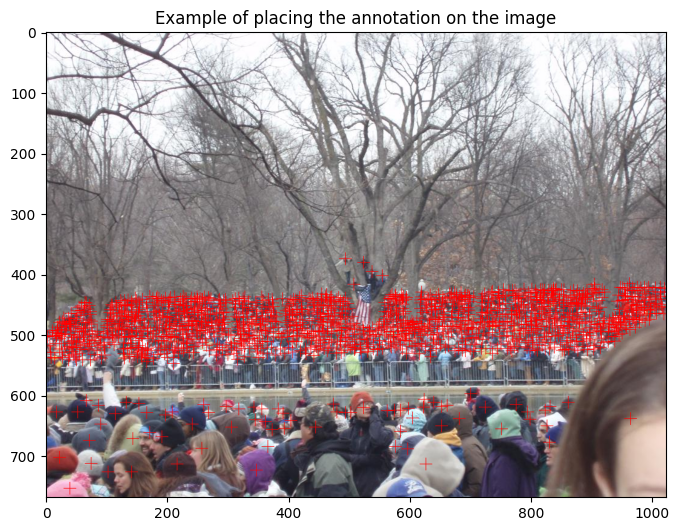

In [7]:
img    = cv2.cvtColor(cv2.imread(train_img_dir_list[0]),cv2.COLOR_BGR2RGB)

annots = loadmat(train_gt_dir_list[0])
annots = annots["image_info"][0][0][0][0][0]

figure = plt.figure(figsize=(8,8))

for e_x_cor, e_y_cor in annots:
    e_x_cor = int(e_x_cor)
    e_y_cor = int(e_y_cor)
    cv2.drawMarker(img, (e_x_cor, e_y_cor), (255, 0, 0), markerType =0)

plt.imshow(img)
plt.title("Example of placing the annotation on the image")
plt.show()

## Use pre-trained VGG16 to obtain the feature of the image
* VGG16.features will take 
    * input  shape: (3,x,y) 
    * output shape: (512, x/32, y/32)  

In [8]:
if USE_PYTORCH_VGG16:
    print("Loading model from pytorch...")
    vgg16_pretrained = vgg16(weights="VGG16_Weights.IMAGENET1K_V1").features.to(device)
else:
    vgg16_pretrained = VGG16_BackBone().to(device)
    if os.path.exists("backbone.pth.tar"):
        print("Loading model from backbone.pth.tar...")
        vgg16_pretrained.load_state_dict(torch.load('backbone.pth.tar')['state_dict'])
    else:
        del vgg16_pretrained
        raise("Pretrained VGG-16 (backbone.pth.tar) does not exists")

for param in vgg16_pretrained.parameters():
    param.requires_grad = False

summary(vgg16_pretrained, (3, 320, 320))
print("Done")

Loading model from backbone.pth.tar...
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 320, 320]        (1,792)
├─ReLU: 1-2                              [-1, 64, 320, 320]        --
├─Conv2d: 1-3                            [-1, 64, 320, 320]        (36,928)
├─ReLU: 1-4                              [-1, 64, 320, 320]        --
├─MaxPool2d: 1-5                         [-1, 64, 160, 160]        --
├─Conv2d: 1-6                            [-1, 128, 160, 160]       (73,856)
├─ReLU: 1-7                              [-1, 128, 160, 160]       --
├─Conv2d: 1-8                            [-1, 128, 160, 160]       (147,584)
├─ReLU: 1-9                              [-1, 128, 160, 160]       --
├─MaxPool2d: 1-10                        [-1, 128, 80, 80]         --
├─Conv2d: 1-11                           [-1, 256, 80, 80]         (295,168)
├─ReLU: 1-12                             [-1, 256, 80, 80]         --
├─Conv2d: 1-13 

## Pre-process the data

### Convert the ground-truth from .mat format into .csv format

In [9]:
os.makedirs(dataset_dir + train_gt_csv, exist_ok=True)
os.makedirs(dataset_dir + test_gt_csv, exist_ok=True)

grid_size = (32,32)  # Grid_size after downsample the image from (3, 1024, 1024) to (512, 32, 32) 

# Conver the .mat format into .csv format
for data_name, gt_csv, gt_dir in [["Train", train_gt_csv, train_gt_dir_list], ["Test", test_gt_csv, test_gt_dir_list]]:
    print(f"\nFor {data_name} dataset")
    
    for gt_filename in gt_dir: # For each of the ground truth file
        filename = gt_filename[gt_filename.rindex("/")+1:-4]  # Get the filename
        if not os.path.exists(f"{dataset_dir}{gt_csv}{filename}.csv"):
        
            annots = loadmat(gt_filename)                         # Load the matlab file
            annots = annots["image_info"][0][0][0][0][0]          # Extract the annotation from the file
            
            data = np.zeros(grid_size, dtype = np.int16)              
            for x, y in annots:                                   # Store the annotation in numpy array based on 32x32 grid
                data[int(y//32), int(x//32)] += 1    # In image, x is -- , y is | , however, when storing in array, x is |, y is --
            
            df = pd.DataFrame(data).to_csv(f"{dataset_dir}{gt_csv}{filename}.csv", 
                                        index=False,
                                        header=False)
            
            print(f"For {filename:<11}, it have {annots.shape[0]:<4} points, the num of points for each grid is saved to {dataset_dir}{gt_csv}{filename}.csv")
    print("DONE")

print("\nAll .mat file have been converted to .csv file")


For Train dataset
DONE

For Test dataset
DONE

All .mat file have been converted to .csv file


### Extract the features from each images using VGG16 and save it into .pt file

In [10]:
%%time
if os.path.isdir(f"{dataset_dir}{train_img_pt}"):
    shutil.rmtree(f"{dataset_dir}{train_img_pt}")
if os.path.isdir(f"{dataset_dir}{test_img_pt}"):
    shutil.rmtree(f"{dataset_dir}{test_img_pt}")

os.makedirs(f"{dataset_dir}{train_img_pt}", exist_ok=True)
os.makedirs(f"{dataset_dir}{test_img_pt}", exist_ok=True)

for img_pt, img_dir_list in zip([train_img_pt, test_img_pt], [train_img_dir_list, test_img_dir_list]):
    for i, img_filename in enumerate(img_dir_list):
        filename = img_filename[img_filename.rindex("/")+1:-4]               # Get the filename
        if not os.path.exists(f"{dataset_dir}{img_pt}{filename}.pt"):  # If the path not exist
            img       = cv2.imread(img_filename)
            if USE_PYTORCH_VGG16:
                transform = transforms.Compose([transforms.ToTensor(),   # Convert image to range [0,1] and shape from (H,W,3) to (3,H,W)
                                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
                                                
                img       = transform(img)     # Transform the image so it follow the VGG16_Weights.IMAGENET1K_V1.transforms
            else:
                transform = transforms.Compose([transforms.ToTensor()])  # Convert image to range [0,1] and shape from (H,W,3) to (3,H,W)
                img       = transform(img)
                means     = [[108.25673428], [ 97.02240046], [ 93.37483706]]
                means     = torch.FloatTensor( np.array(means) / 255).unsqueeze_(2) # Shape = (3,1,1)
                img       = img - means
                
            # Add padding to image so the final image have shape (3, max_x, max_y)
            img_pad   = torch.zeros((3, max_x, max_y)) 
            img_pad[:, :img.shape[1], :img.shape[2]] = img.clone()

            img_feature = vgg16_pretrained(img_pad.to(device))
            print(f"Image {i}")
            print(f"original shape: {img.shape}")
            print(f"After padding and pass through pretrained vgg16, shape: {img_feature.shape}")
            print(f"The features tensor have been save to {dataset_dir}{img_pt}{filename}.pt\n")
            
            torch.save(img_feature, f"{dataset_dir}{img_pt}{filename}.pt")
            
print("All images' features have been extracted and save to .pt file")

Image 0
original shape: torch.Size([3, 768, 1024])
After padding and pass through pretrained vgg16, shape: torch.Size([512, 32, 32])
The features tensor have been save to ShanghaiTech/part_A/train_data/images-pt/IMG_1.pt

Image 1
original shape: torch.Size([3, 683, 1024])
After padding and pass through pretrained vgg16, shape: torch.Size([512, 32, 32])
The features tensor have been save to ShanghaiTech/part_A/train_data/images-pt/IMG_10.pt

Image 2
original shape: torch.Size([3, 654, 1024])
After padding and pass through pretrained vgg16, shape: torch.Size([512, 32, 32])
The features tensor have been save to ShanghaiTech/part_A/train_data/images-pt/IMG_100.pt

Image 3
original shape: torch.Size([3, 768, 1024])
After padding and pass through pretrained vgg16, shape: torch.Size([512, 32, 32])
The features tensor have been save to ShanghaiTech/part_A/train_data/images-pt/IMG_101.pt

Image 4
original shape: torch.Size([3, 768, 1024])
After padding and pass through pretrained vgg16, shape: 

In [11]:
# Release the memory
del vgg16_pretrained
torch.cuda.empty_cache()

### Split the training dataset in 90% training and 10% validation

In [8]:
# Obtain the paths to point to the processed label (.csv) file and processed image (.pt) file
train_img_pt_list  = [dataset_dir + train_img_pt  + filename for filename in sorted(os.listdir(dataset_dir + train_img_pt)) if filename.endswith(".pt")]
train_gt_csv_list  = [dataset_dir + train_gt_csv  + filename for filename in sorted(os.listdir(dataset_dir + train_gt_csv)) if filename.endswith(".csv")]

test_img_pt_list  = [dataset_dir + test_img_pt  + filename for filename in sorted(os.listdir(dataset_dir + test_img_pt)) if filename.endswith(".pt")]
test_gt_csv_list  = [dataset_dir + test_gt_csv  + filename for filename in sorted(os.listdir(dataset_dir + test_gt_csv)) if filename.endswith(".csv")]

print(len(train_img_pt_list), train_img_pt_list)
print(len(train_gt_csv_list), train_gt_csv_list)
print(len(test_img_pt_list) , test_img_pt_list)
print(len(test_gt_csv_list) , test_gt_csv_list)

300 ['ShanghaiTech/part_A/train_data/images-pt/IMG_1.pt', 'ShanghaiTech/part_A/train_data/images-pt/IMG_10.pt', 'ShanghaiTech/part_A/train_data/images-pt/IMG_100.pt', 'ShanghaiTech/part_A/train_data/images-pt/IMG_101.pt', 'ShanghaiTech/part_A/train_data/images-pt/IMG_102.pt', 'ShanghaiTech/part_A/train_data/images-pt/IMG_103.pt', 'ShanghaiTech/part_A/train_data/images-pt/IMG_104.pt', 'ShanghaiTech/part_A/train_data/images-pt/IMG_105.pt', 'ShanghaiTech/part_A/train_data/images-pt/IMG_106.pt', 'ShanghaiTech/part_A/train_data/images-pt/IMG_107.pt', 'ShanghaiTech/part_A/train_data/images-pt/IMG_108.pt', 'ShanghaiTech/part_A/train_data/images-pt/IMG_109.pt', 'ShanghaiTech/part_A/train_data/images-pt/IMG_11.pt', 'ShanghaiTech/part_A/train_data/images-pt/IMG_110.pt', 'ShanghaiTech/part_A/train_data/images-pt/IMG_111.pt', 'ShanghaiTech/part_A/train_data/images-pt/IMG_112.pt', 'ShanghaiTech/part_A/train_data/images-pt/IMG_113.pt', 'ShanghaiTech/part_A/train_data/images-pt/IMG_114.pt', 'Shanghai

In [9]:
NUM_TRAIN = 270        # Total number of training data
NUM_VALID = 30         # Total number of validation data
              
valid_img_pt_list = train_img_pt_list[-NUM_VALID:]
valid_gt_csv_list = train_gt_csv_list[-NUM_VALID:]
train_img_pt_list = train_img_pt_list[:NUM_TRAIN]
train_gt_csv_list = train_gt_csv_list[:NUM_TRAIN]

print("After splitting:")
print("Training   data:", len(train_img_pt_list))
print("Validation data:", len(valid_img_pt_list))
print("Testing    data:", len(test_img_pt_list))

After splitting:
Training   data: 270
Validation data: 30
Testing    data: 182


In [10]:
# Calculate the maximum count of person for 1 grid in the image after splitting to (32, 32)
def get_max_count(gt_csv_list):
    max_value = 0
    for path_ in gt_csv_list:
        df = pd.read_csv(path_, header=None)
        if df.to_numpy().max() > max_value:
            max_value = df.to_numpy().max()
    return max_value
print("Max count for 1 grid in train dataset:",get_max_count(train_gt_csv_list))
print("Max count for 1 grid in valid dataset:",get_max_count(valid_gt_csv_list))
print("Max count for 1 grid in test  dataset:",get_max_count(test_gt_csv_list))

Max count for 1 grid in train dataset: 52
Max count for 1 grid in valid dataset: 32
Max count for 1 grid in test  dataset: 39


## Create the model


### Settings when training the model

Device Used: cuda


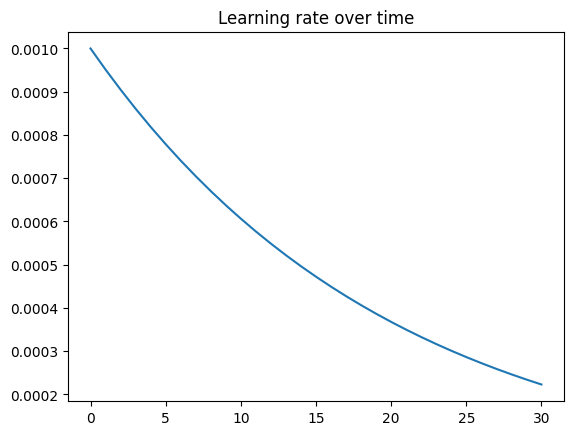

In [11]:

parameters = {'TRAIN_SKIP':100,
             'BUFFER_LENGTH':50000,
             'ERROR_RANGE':0.5,
             'GAMMA':0.9,
             "BATCH_SIZE_IMG":30,     # Number of image load per sampling from episode
             'BATCH_SIZE_GRID':512,   # Number of grid  load for training
             'Interval_N':57,
             'step_log':0.1,
             'start_log':-2,
             'NUM_STEP_ALLOW':8,           # Number of step allow in each grid of image
             'ACTION_NUMBER':6,
             'ERROR_SYSTEM':0}


epoch_start     = 0
num_epoch_train = 31

# Exponential Decay Learning Rate
k               = 0.05
initial_lr      = 0.001
lr_list         = initial_lr * np.ones(num_epoch_train)
lr_list         = [lr*np.exp(-k*t) for t, lr in enumerate(lr_list)]
plt.plot(lr_list)
plt.title("Learning rate over time")


print("Device Used:", device)

In [12]:
Libranet = LibraNet(parameters=parameters).to(device)   

In [13]:
# It will output action value for all possible action
summary(Libranet.DQN, ((512, 1,1), (parameters['NUM_STEP_ALLOW'], 1,1)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 1024, 1, 1]          533,504
├─ReLU: 1-2                              [-1, 1024, 1, 1]          --
├─Conv2d: 1-3                            [-1, 1024, 1, 1]          1,049,600
├─ReLU: 1-4                              [-1, 1024, 1, 1]          --
├─Conv2d: 1-5                            [-1, 6, 1, 1]             6,150
Total params: 1,589,254
Trainable params: 1,589,254
Non-trainable params: 0
Total mult-adds (M): 1.59
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 6.06
Estimated Total Size (MB): 6.08


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 1024, 1, 1]          533,504
├─ReLU: 1-2                              [-1, 1024, 1, 1]          --
├─Conv2d: 1-3                            [-1, 1024, 1, 1]          1,049,600
├─ReLU: 1-4                              [-1, 1024, 1, 1]          --
├─Conv2d: 1-5                            [-1, 6, 1, 1]             6,150
Total params: 1,589,254
Trainable params: 1,589,254
Non-trainable params: 0
Total mult-adds (M): 1.59
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 6.06
Estimated Total Size (MB): 6.08

## Train the model

In [14]:
# # When testing, try a smaller subset when training
# train_img_pt_list = train_img_pt_list[:30]
# train_gt_csv_list = train_gt_csv_list[:30]
# epoch_start       = 0
# num_epoch_train   = 5

In [15]:
def print_and_save_log(messages, log_path):
    with open(log_path, 'a') as f: 
        f.write(messages + "\n")
    print(messages)

In [16]:
VGG_name = "" if USE_PYTORCH_VGG16 else "_THF" # THF = Trained for obtaining human features
 
for LOSS_FUNCTION in ["QL","CE", "CB"]: # For loss function in [Q learning loss, cross entropy loss, combine of Q learning loss and cross entropy]
    for TRAIN_WITH_OPTIMAL_ACTION in [False, True]:      
        optimal_str = "opt" if TRAIN_WITH_OPTIMAL_ACTION else "N_opt"
        MODEL_DIR = f"Models{VGG_name}/Model_{LOSS_FUNCTION}_{optimal_str}"
        RESULT_DIR= f"Results{VGG_name}/Result_{LOSS_FUNCTION}_{optimal_str}"
        
        os.makedirs(f"Results{VGG_name}", exist_ok=True)
        os.makedirs(f"Models{VGG_name}", exist_ok=True)
        os.makedirs(MODEL_DIR, exist_ok=True) 
        os.makedirs(RESULT_DIR, exist_ok=True)
        
        # Create the model and replay buffer
        delimiter = "-" * 100 + "\n"
        print_and_save_log(delimiter + f"Start training using the loss {LOSS_FUNCTION} and TRAIN_WITH_OPTIMAL_ACTION={TRAIN_WITH_OPTIMAL_ACTION}" + "\n" + delimiter, f"{RESULT_DIR}/log.txt")
        Libranet = LibraNet(parameters=parameters).to(device)      
        replay   = ReplayBuffer(size=parameters['BUFFER_LENGTH'], 
                                vector_len_fv=512, 
                                vector_len_hv=parameters['NUM_STEP_ALLOW'], 
                                batch_size=parameters['BATCH_SIZE_GRID'])
        
        # Load the model and results
        list_model = os.listdir(MODEL_DIR)
        if len(list_model) != 0:
            list_model.remove("DQN_best.tar")
            num_list   = [int(model_dir[model_dir.rindex("_") +1: model_dir.rindex(".")]) for model_dir in list_model ]
            num_max    = np.max(num_list)
        else:
            num_max = 0
        best_model_path = f'{MODEL_DIR}/DQN_ckpt_{num_max}.tar'
        if os.path.exists(best_model_path):
            load_item = torch.load(best_model_path)
            Libranet.load_state_dict(load_item['state_dict'])
            epoch_start = load_item['epoch'] + 1
            mae         = load_item["mae"]
            mse         = load_item["mse"]
            
            lowest_mae  = torch.load(f'{MODEL_DIR}/DQN_best.tar')["mae"]
            lowest_mse  = torch.load(f'{MODEL_DIR}/DQN_best.tar')["mse"]
            print(f"Load the latest pretrained model that will start the epoch at {epoch_start}")
            print(f"Previous mae and mse on validation dataset:", lowest_mae, lowest_mse)
        else:
            epoch_start = 0
            lowest_mae = 10000

        if os.path.exists(f"{RESULT_DIR}/results.csv"):
            df = pd.read_csv(f"{RESULT_DIR}/results.csv")
            list_info  = df.to_numpy()[:epoch_start,:].tolist()
            print(f"Load prev results from {RESULT_DIR}/results.csv")
        else:
            list_info  = []
        
        
        
        # Start training
        valid_count    = 0
        MAX_VALID_COUNT= 30
        for epoch in range(epoch_start, num_epoch_train): 
            
            print_and_save_log(f"> > > Epoch {epoch} < < <\n", f"{RESULT_DIR}/log.txt")

            # Update the weight for DQN with fixed weight
            Libranet.DQN_fixed_w.load_state_dict(Libranet.DQN.state_dict())        
            
            # Create the optimizer with decaying learning rate
            optimizer = torch.optim.Adam([{'params':Libranet.DQN.parameters(), 
                                        'lr':lr_list[epoch]}]) 

            # Train the model
            train_loss = train_model(Libranet, epoch, parameters, replay, 
                                     optimizer, train_img_pt_list, train_gt_csv_list, device,
                                     LOSS_FUNCTION=LOSS_FUNCTION, TRAIN_WITH_OPTIMAL_ACTION=TRAIN_WITH_OPTIMAL_ACTION)
            train_mae, train_mse = evaluate_model(Libranet, parameters, 
                                                  train_img_pt_list, train_gt_csv_list, device)
            valid_mae, valid_mse = evaluate_model(Libranet, parameters, 
                                                  valid_img_pt_list, valid_gt_csv_list, device)
            
            

            ##Save model
            if valid_mae < lowest_mae:
                state_best = {
                    'state_dict':Libranet.state_dict(),
                    'epoch':epoch,
                    'mae':valid_mae,
                    'mse':valid_mse
                }
                torch.save(state_best, f'{MODEL_DIR}/DQN_best.tar')
                print_and_save_log("Save current best model!", f"{RESULT_DIR}/log.txt")
                lowest_mae = valid_mae
                valid_count = 0
            else: 
                valid_count += 1
                        
            
            if epoch % 5 == 0:  
                state_ckpt = {
                        'state_dict':Libranet.state_dict(),
                        'epoch':epoch,
                        'mae':valid_mae,
                        'mse':valid_mse
                    }
                torch.save(state_ckpt, f'{MODEL_DIR}/DQN_ckpt_{epoch}.tar')


            if valid_count == MAX_VALID_COUNT:
                print_and_save_log(f"Training converge as validation loss is not decreasing for {MAX_VALID_COUNT} continuous epoch", f"{RESULT_DIR}/log.txt")
                break

            # Logging 
            print_and_save_log(f"Epoch {epoch:<2}/{num_epoch_train}, Train Loss : {train_loss:.6f}", f"{RESULT_DIR}/log.txt")
            print_and_save_log(f"            Train MAE    : {train_mae:.2f}", f"{RESULT_DIR}/log.txt")
            print_and_save_log(f"            Train MSE    : {train_mse:.2f}", f"{RESULT_DIR}/log.txt")
            print_and_save_log(f"            Valid MAE    : {valid_mae:.2f}", f"{RESULT_DIR}/log.txt")
            print_and_save_log(f"            Valid MSE    : {valid_mse:.2f}", f"{RESULT_DIR}/log.txt")
                        
            list_info.append([train_loss, train_mae, train_mse, valid_mae, valid_mse])
            df_temp = pd.DataFrame(np.array(list_info), columns=["Train Loss", "Train mae", "Train mse", "Valid mae", "Valid mse"])
            df_temp.to_csv(f"{RESULT_DIR}/results.csv", index=False)
        
print("Training finish!")

----------------------------------------------------------------------------------------------------
Start training using the loss QL and TRAIN_WITH_OPTIMAL_ACTION=False
----------------------------------------------------------------------------------------------------

> > > Epoch 0 < < <

Train with QL that guided by optimal action? False
Generate episode from 1 batch of data
Generate episode from 2 batch of data
Generate episode from 3 batch of data
Generate episode from 4 batch of data
Generate episode from 5 batch of data
Generate episode from 6 batch of data
Generate episode from 7 batch of data
Generate episode from 8 batch of data
Generate episode from 9 batch of data
Save current best model!
Epoch 0 /31, Train Loss : 0.282647
            Train MAE    : 238.47
            Train MSE    : 138954.45
            Valid MAE    : 275.53
            Valid MSE    : 241115.67
> > > Epoch 1 < < <

Train with QL that guided by optimal action? False
Generate episode from 1 batch of data
Ge